### 4. Modeling
> The goal of this notebook is to build a model that can predict the status of a Tanzanian well based on the features in our dataset. The model will be evaluated on the accuracy of its predictions. Specifically, if it achieves an accuracy of 75% or higher, it will be considered a success.

In order to achieve the targets stipulated in the project proposal, we will be using the following algorithms:
- Logistic Regression
- Decision Tree
- Random Forest
- K-Nearest Neighbors

We will also be using the following metrics to evaluate the performance of our models:
-  Accuracy

To ensure that our models are not overfitting, we will be using the following techniques:
-  Cross Validation

In [29]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
#preview the new data
import pandas as pd
df = pd.read_csv('cleaned_data.csv')
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,basin,subvillage,region,local_government_area,ward,...,permit,construction_year,extraction_type_group,management_group,payment_type,water_quality,quantity,source_type,waterpoint_type,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,...,False,1999,gravity,user-group,annually,soft,enough,spring,communal standpipe,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,Lake Victoria,Nyamara,Mara,Serengeti,Natta,...,True,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,world vision,Pangani,Majengo,Manyara,Simanjiro,Ngorika,...,True,2009,gravity,user-group,per bucket,soft,enough,dam,communal standpipe multiple,functional
3,0.0,2013-01-28,Unicef,263,Unicef,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,...,True,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe multiple,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,...,True,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional


In [3]:
#getting a copy of our dataframe
df1 = df.copy()

In [37]:
#checking the value count of target group
df1['status_group'].value_counts(normalize=True)

1    0.541287
0    0.387962
2    0.070751
Name: status_group, dtype: float64

The functional group accounts for 54.1% of the dataset. The non-functional group accounts for 38.8% of the dataset. The functional needs repair group accounts for 7% of the dataset.

In [5]:
new_status_group = {'non functional': 0, 'functional': 1, 'functional needs repair' : 2}
df1['status_group'] = df1['status_group'].replace(new_status_group)

In [6]:
df1['status_group'].value_counts()

1    29210
0    20936
2     3818
Name: status_group, dtype: int64

Since the data type is object, we need to convert it to an integer

In [7]:
df1['status_group'].dtypes

dtype('int64')

In [8]:
# One hot encode categoricals

categorical = ['source_type','quantity','water_quality','payment_type','management_group','basin']

ohe = pd.get_dummies(df[categorical], prefix=categorical, drop_first=True)
ohe

,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,...,management_group_unknown,management_group_user-group,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu
0,0,0,0,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
53960,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
53961,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
53962,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [9]:
# Preview the one hot encoded datatypes
ohe.dtypes

source_type_dam                     uint8
source_type_other                   uint8
source_type_rainwater harvesting    uint8
source_type_river/lake              uint8
source_type_shallow well            uint8
source_type_spring                  uint8
quantity_enough                     uint8
quantity_insufficient               uint8
quantity_seasonal                   uint8
quantity_unknown                    uint8
water_quality_fluoride              uint8
water_quality_fluoride abandoned    uint8
water_quality_milky                 uint8
water_quality_salty                 uint8
water_quality_salty abandoned       uint8
water_quality_soft                  uint8
water_quality_unknown               uint8
payment_type_monthly                uint8
payment_type_never pay              uint8
payment_type_on failure             uint8
payment_type_other                  uint8
payment_type_per bucket             uint8
payment_type_unknown                uint8
management_group_other            

In [10]:
# Define X and y
X = ohe
y = df1['status_group']

# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Print head train
print(X_train.shape)

# Print head test
print(y_train.shape)

(43171, 35)
(43171,)


We can confirm that the x_train and y_train dataframes have the same number of rows. Therefore, we can proceed to the modelling.

#### 4.1 Logistic Regression
> Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

In [33]:
# Instantiate logistic regression
logreg = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# Build a pipeline with standard scaler and logistic regression
scaled_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('logreg', LogisticRegression())])

# Fit the training data to pipeline
scaled_pipeline.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_log = scaled_pipeline.predict(X_test)

# Perform cross-validation: cv_results
cv_results_log = cross_validate(scaled_pipeline, X_test, y_test, cv=3)

# Display cross validation test scores
cv_results_log['test_score']

array([0.67065036, 0.67537521, 0.6647206 ])

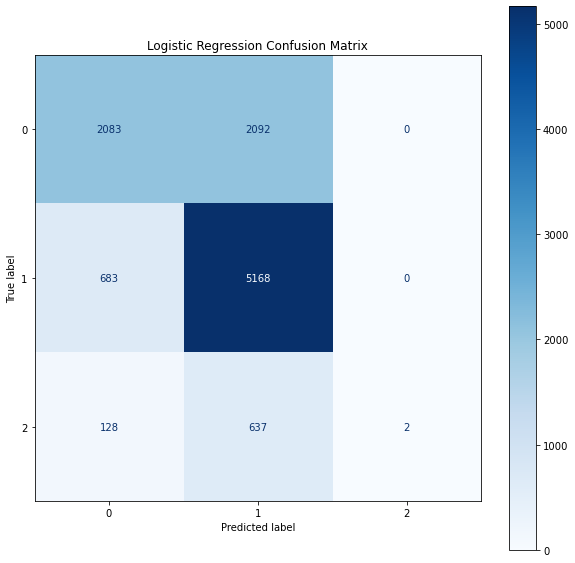

In [12]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(scaled_pipeline, X_test, y_test, cmap='Blues', ax=ax)
plt.title("Logistic Regression Confusion Matrix");

The confusion matrix above shows that the model has a bias towards predicting that a well is functional. Furthermore, we see that the model has a higher number of true positives and true negatives than false positives and false negatives.

In [13]:
# Classification report
target_names = ['Non-Functional', 'Functional', 'Needs-Repair']

print(classification_report(y_test, y_pred_log, target_names=target_names))

                precision    recall  f1-score   support

Non-Functional       0.72      0.50      0.59      4175
    Functional       0.65      0.88      0.75      5851
  Needs-Repair       1.00      0.00      0.01       767

      accuracy                           0.67     10793
     macro avg       0.79      0.46      0.45     10793
  weighted avg       0.70      0.67      0.64     10793



The logisctic regression model has an accuracy of 0.67. This is a good start for a baseline model.

### 4.2 Decision Tree
> Decision trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [34]:
# Instantiate the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', random_state=39)

# Fit train data to classifier
clf.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred_dt = clf.predict(X_test)

# Perform cross-validation: cv_results
cv_results_dt = cross_validate(clf, X_test, y_test, cv=3)

# Display cross validation test scores
cv_results_dt['test_score']

array([0.67898833, 0.67954419, 0.67528496])

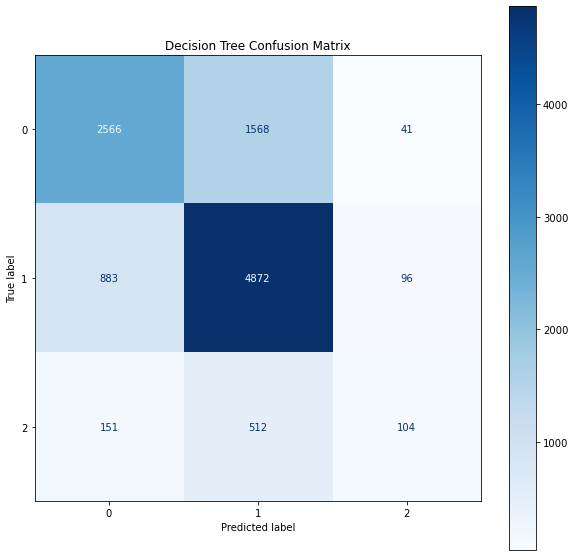

In [15]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', ax=ax)
plt.title("Decision Tree Confusion Matrix");

In [16]:
# Classification report
target_names = ['Non-Functional', 'Functional', 'Needs-Repair']

print(classification_report(y_test, y_pred_dt, target_names=target_names))

                precision    recall  f1-score   support

Non-Functional       0.71      0.61      0.66      4175
    Functional       0.70      0.83      0.76      5851
  Needs-Repair       0.43      0.14      0.21       767

      accuracy                           0.70     10793
     macro avg       0.62      0.53      0.54     10793
  weighted avg       0.69      0.70      0.68     10793



From our classification report, we can see that the accuracy of our model is 0.70. This is a better result that the first model that we used, however, it is still less less than our desired accuracy of 75%

#### 4.3 K Nearest Neighbors
> KNN is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition already in the beginning of 1970’s as a non-parametric technique.

In [17]:
# #Build a pipeline with KNN and a scaler
# scaled_knn_pipeline = Pipeline([('ss', StandardScaler()),
#                               ('knn', KNeighborsClassifier())]) 

# # Fit KNN pipeline
# scaled_knn_pipeline.fit(X_train, y_train)

# # Check the score of the KNN pipeline
# print("accuracy score :", scaled_knn_pipeline.score(X_test, y_test))

#### 4.4 Random Forest
> Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

In [36]:
# Build a pipeline with StandardScaler and RandomForestClassifier
random_pipeline = Pipeline([('ss', StandardScaler()), 
                            ('RF', RandomForestClassifier(random_state=0))])

# Fit the training data to pipeline 
random_pipeline.fit(X_train, y_train)

# Predict the labels of the test set: y_pred_rf
y_pred_rf = random_pipeline.predict(X_test)

# Perform cross-validation: cv_results_rf
cv_results_rf = cross_validate(random_pipeline, X_test, y_test, cv=3)

# Display cross validation test scores
cv_results_rf['test_score']

array([0.68343524, 0.68037799, 0.67973311])

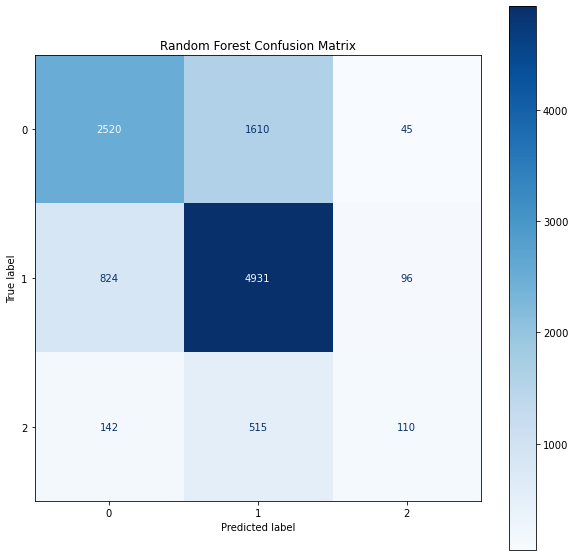

In [24]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(random_pipeline, X_test, y_test, cmap='Blues', ax=ax)
plt.title("Random Forest Confusion Matrix");

In [25]:
# Classification report
target_names = ['Non-Functional', 'Functional', 'Needs-Repair']

print(classification_report(y_test, y_pred_rf, target_names=target_names))

                precision    recall  f1-score   support

Non-Functional       0.72      0.60      0.66      4175
    Functional       0.70      0.84      0.76      5851
  Needs-Repair       0.44      0.14      0.22       767

      accuracy                           0.70     10793
     macro avg       0.62      0.53      0.55     10793
  weighted avg       0.69      0.70      0.68     10793



The classification report once again shows a model that has an accuracy of 0.7 percent. This is the same as the decision tree model.

#### 4.5 XGBoost
> XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

In [27]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

KeyboardInterrupt: 

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

#### Evaluation
> The evaluation metric for this competition is the categorization accuracy of each well's operational status. This is the percentage of pumps that are classified correctly.

In this project, we have used the following alogrithms to predict the status of a Tanzanian well and these were the results:

##### Logistic Regression
- The logistic regression model returned and accuracy of 67%. Though this was not our desired accuracy, it was a good for a baseline model and gave us a good starting point for our other models.
- The confusion maxtrix evaluation showed that the model had a bias towards predicting that a well is functional. Furthermore, we saw that the model had a higher number of true positives and true negatives than false positives and false negatives. This therefore meant that the model was not overfitting.
- The cross validation results returned consistent scores. This ensured that we were not overfitting our data

##### Decision Tree
- The decision tree model returned an accuracy of 70%. This was a better result that our baseline model (logistic regression). However, despite improving the accuracy, it was still less than our desired accuracy of 75%.
- The cross validation once again returned balanced consistent values accross the tests
- The confusion maxtrix evaluation showed that the model had a bias towards predicting that a well is functional. Furthermore, we saw that the model had a higher number of true positives and true negatives than false positives and false negatives. This therefore meant that the model was not overfitting.

##### Random Forest
- Our random forest model also returned an accuracy of 70%. This was the same as the decision tree model. This meant that the random forest model was not better than the decision tree model. The cross validation once again returned balanced consistent values accross the tests
- the confusion maxtrix evaluation showed that the model had a bias towards predicting that a well is functional. Furthermore, we saw that the model had a higher number of true positives and true negatives than false positives and false negatives. This therefore meant that the model was not overfitting.

##### K Nearest Neighbors
- Unfortunately our KNN algorithm returned some errors and was not able to run.

##### XGBoost
- 

--- 

### How did we evaluate our models?
- We used a pipeline to scale the data and then fit it to the model. We then used cross validation to ensure that our model was not overfitting. We also used a confusion matrix to evaluate the performance of our model.
- Despite the fact that our models did not achieve the desired accuracy of 75%, we were able to achieve an accuracy of 70% which is a good start for our project and is within an acceptable range of +/- 5%


#### Limitations
The limitations that we encountered in this experiment were:
- Eventhough, the model reached our standard, there is still 30% that is not accounted for in our results
- Due to the time constraint, we were not able to do further feature engineering
- There was a class imbalance acrros the three ourput variables (functional. non-functional, needs-repair)
- As Tanzania is a very big country regions have different factors that will affect our models differently. It would have been better to have different models for different regions.